<a href="https://colab.research.google.com/github/JohnOngeri/FraudDetection/blob/main/Summative_Intro_to_ml_%5BJohn_Ongeri_Ouma_number%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [4]:
#Import Necessary Libraries

# ========== 📊 Data Handling ==========
import pandas as pd
import numpy as np

# ========== 🧼 Preprocessing ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample  # if balancing classes
from imblearn.combine import SMOTEENN  # for class imbalance

# ========== 📈 Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== ⚙️ Classical ML Models ==========
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ========== 📊 Model Evaluation ==========
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# ========== 🧠 Neural Networks ==========
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import load_model

# ========== 💾 Model Saving ==========
import joblib  # for ML models like XGBoost, SVM
import os

# ========== 🛠️ Warnings ==========
import warnings
warnings.filterwarnings('ignore')

# ========== 📅 Optional: for timestamping models ======
from datetime import datetime



# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


1.Problem defintion
Fraud detection in mobile money transactions. Predicting whether the transaction if a fraud or not

The dataset can be downloaded from: https://www.kaggle.com/code/tomaszurban/fraud-detection-in-mobile-transactions/input

This dataset contains mobile money transactions which were generated with PaySim simulator. The simulation was based on a sample of real transactions gathered by a company who is the provider of the mobile financial service which is currently runnig in more than 14 countries all around the world. The data is a set of one month financial logs from a mobile money service implemented in an African country.

The data is gathered in one CSV file. One line sample row: 1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

The dataset contains (following the example above):

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [20]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)

# Using raw string with backslashes
data = pd.read_csv(r'C:\Users\HP\FraudDetection\fraud.csv')

# Preview the first 5 rows
data.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [21]:
# Drop ID columns that don't help model learning
data = data.drop(['nameOrig', 'nameDest'], axis=1)


In [22]:
# Convert 'type' column to numerical (one-hot encoding)
data = pd.get_dummies(data, columns=['type'], drop_first=True)

# Confirm all are now numeric
print(data.dtypes)


step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object


In [23]:
# Define X and y
X = data.drop(columns=['isFraud'])  # Features
y = data['isFraud']                 # Target


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [25]:
from sklearn.model_selection import train_test_split

# 80% temp, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 75% of temp for training, 25% for validation → 60/20/20 split overall
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


In [26]:
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)
print("Test set shape: ", X_test.shape)

print("\nClass distribution in each split:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Validation:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))


Training set shape:  (629145, 11)
Validation set shape:  (209715, 11)
Test set shape:  (209715, 11)

Class distribution in each split:
Train:
 isFraud
0    0.99891
1    0.00109
Name: proportion, dtype: float64
Validation:
 isFraud
0    0.998913
1    0.001087
Name: proportion, dtype: float64
Test:
 isFraud
0    0.998913
1    0.001087
Name: proportion, dtype: float64


In [27]:
num_fraud = (data["isFraud"] == 1).sum()
num_non_fraud = (data["isFraud"] == 0).sum()
num_flagged_fraud = (data["isFlaggedFraud"] == 1).sum()

print(f"Fraudulent transactions: {num_fraud}")
print(f"Non-fraudulent transactions: {num_non_fraud}")
print(f"Flagged as fraud (by system): {num_flagged_fraud}")


Fraudulent transactions: 1142
Non-fraudulent transactions: 1047433
Flagged as fraud (by system): 0


 Preprocessing and Class Balancing
Because i am working on a fraud detection problem with extreme class imbalance, i need to:

✅ Step 1: Handle Class Imbalance with SMOTEENN (on training set only)
This helps the model see more fraud cases during training.

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Optional: Check class balance
# Count of each class in training set
print("After SMOTE (balanced y_train):")
print(pd.Series(y_train).value_counts())


After SMOTE (balanced y_train):
isFraud
0    628459
1    628459
Name: count, dtype: int64


In [29]:
from sklearn.preprocessing import StandardScaler

# Create the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
print("Fitting and transforming X_train...")
X_train_scaled = scaler.fit_transform(X_train)
print(f"X_train_scaled shape: {X_train_scaled.shape}")

# Transform validation and test sets
print("Transforming X_val...")
X_val_scaled = scaler.transform(X_val)
print(f"X_val_scaled shape: {X_val_scaled.shape}")

print("Transforming X_test...")
X_test_scaled = scaler.transform(X_test)
print(f"X_test_scaled shape: {X_test_scaled.shape}")


Fitting and transforming X_train...
X_train_scaled shape: (1256918, 11)
Transforming X_val...
X_val_scaled shape: (209715, 11)
Transforming X_test...
X_test_scaled shape: (209715, 11)


In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib

# ✅ Use balanced & scaled training set
# Assuming you have:
# X_train_scaled (from X_train_balanced)
# y_train_balanced

# 💡 Reduced parameter grid (only essential, 6 combos)
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear'],  # supports both l1 and l2
    'class_weight': ['balanced']
}

# Create logistic regression model
lr = LogisticRegression(max_iter=200)

# GridSearch with 3-fold CV
lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=lr_params,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# ⏱️ Fit the model
lr_grid.fit(X_train_scaled, y_train)

# 🏆 Best model and parameters
best_lr = lr_grid.best_estimator_
print("Best Logistic Regression Parameters:")
print(lr_grid.best_params_)

# 📊 Evaluate on validation set
y_pred_lr = best_lr.predict(X_val_scaled)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr))




Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Logistic Regression Parameters:
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    209487
           1       0.02      0.95      0.04       228

    accuracy                           0.95    209715
   macro avg       0.51      0.95      0.50    209715
weighted avg       1.00      0.95      0.97    209715



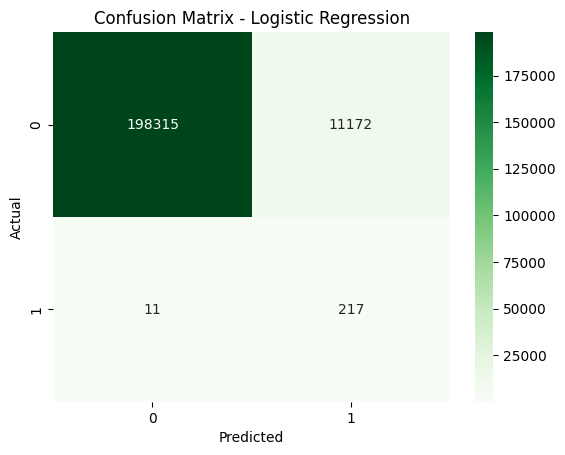

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion matrix

conf_matrix_log = confusion_matrix(y_val, y_pred_lr)
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
import os

# Create the folder if it doesn't already exist
os.makedirs('saved_models', exist_ok=True)


In [19]:
import joblib

joblib.dump(best_lr, 'saved_models/logistic_regression_model.pkl')

['saved_models/logistic_regression_model.pkl']

#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


**Basic Neural Network (No Optimization)**

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report


In [21]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2 # Corrected import statement
from tensorflow.keras.callbacks import EarlyStopping


# Build the model (Instance 1)
model_1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [22]:
# Compile with defaults (no optimizer tuning)
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train on balanced and scaled data (NO EarlyStopping)
history_1 = model_1.fit(
    X_train_scaled,
    y_train,
    epochs=10,  # keep short to avoid overfitting
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

Epoch 1/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.9499 - loss: 0.1186 - val_accuracy: 0.9770 - val_loss: 0.0648
Epoch 2/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step - accuracy: 0.9714 - loss: 0.0676 - val_accuracy: 0.9847 - val_loss: 0.0459
Epoch 3/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.9757 - loss: 0.0592 - val_accuracy: 0.9845 - val_loss: 0.0440
Epoch 4/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 0.9777 - loss: 0.0541 - val_accuracy: 0.9814 - val_loss: 0.0513
Epoch 5/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - accuracy: 0.9796 - loss: 0.0500 - val_accuracy: 0.9799 - val_loss: 0.0505
Epoch 6/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 151s 4ms/step - accuracy: 0.9809 - loss: 0.0467 - val_accuracy: 0.9734 - val_loss: 0.0673
Epoch 7/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - accuracy: 0.9818 - loss: 0.0444 - val_accuracy: 0.9699 - val_loss: 0.0762
Epoch 8/10
39279/39279 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accurac

In [23]:
# Predict on validation set
y_pred_nn_1 = (model_1.predict(X_val_scaled) > 0.5).astype("int32")

# Evaluate
print("Classification Report - Basic Neural Network (Instance 1):")
print(classification_report(y_val, y_pred_nn_1))


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Classification Report - Basic Neural Network (Instance 1):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    209487
           1       0.09      0.93      0.17       228

    accuracy                           0.99    209715
   macro avg       0.55      0.96      0.58    209715
weighted avg       1.00      0.99      0.99    209715



In [24]:
model_1.save('saved_models/nn_instance1_basic.keras')


# Task: Print out the Final Model Accuracy and plot the Loss curve

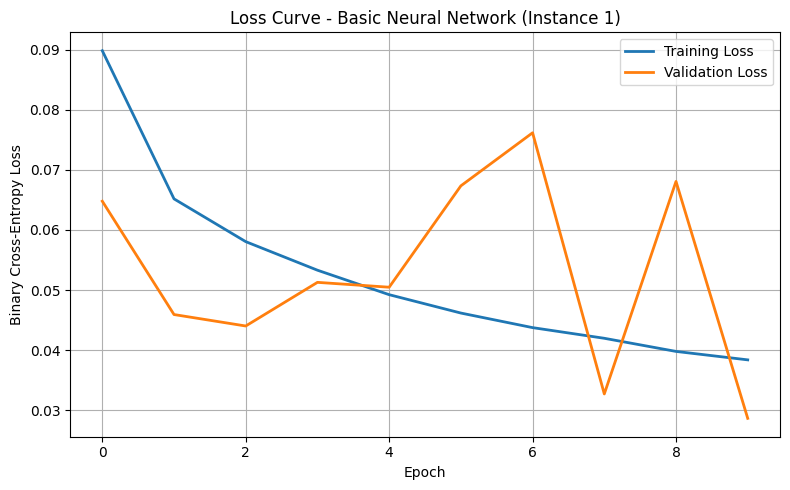

In [25]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_1.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss Curve - Basic Neural Network (Instance 1)')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


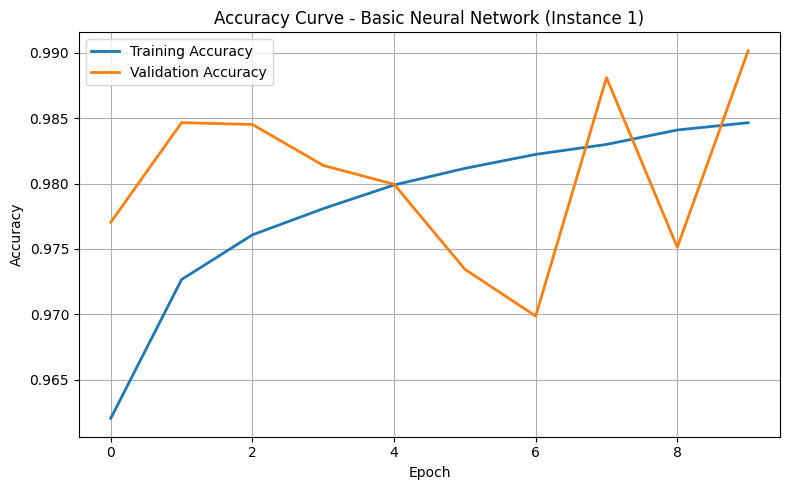

In [26]:
# Plot accuracy (optional)
plt.figure(figsize=(8, 5))
plt.plot(history_1.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy Curve - Basic Neural Network (Instance 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Optimizer with custom learning rate
optimizer = RMSprop(learning_rate=0.0005)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model architecture
model_2 = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Compile model
model_2.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history_2 = model_2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9159 - loss: 0.3330 - val_accuracy: 0.9821 - val_loss: 0.1431
Epoch 2/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9392 - loss: 0.2083 - val_accuracy: 0.9339 - val_loss: 0.2182
Epoch 3/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9435 - loss: 0.1931 - val_accuracy: 0.8712 - val_loss: 0.2933
Epoch 4/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9454 - loss: 0.1857 - val_accuracy: 0.9468 - val_loss: 0.2058
Epoch 5/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9476 - loss: 0.1789 - val_accuracy: 0.9287 - val_loss: 0.2194
Epoch 6/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9495 - loss: 0.1732 - val_accuracy: 0.9781 - val_loss: 0.1391
Epoch 7/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9514 - loss: 0.1687 - val_accuracy: 0.9793 - val_loss: 0.1289
Epoch 8/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 

In [28]:
# Evaluate accuracy
val_loss_2, val_acc_2 = model_2.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\n✅ Instance 2 - Final Validation Accuracy: {val_acc_2:.4f}")
# Save model
model_2.save('saved_models/nn_instance2_optimized.keras')



✅ Instance 2 - Final Validation Accuracy: 0.9900


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


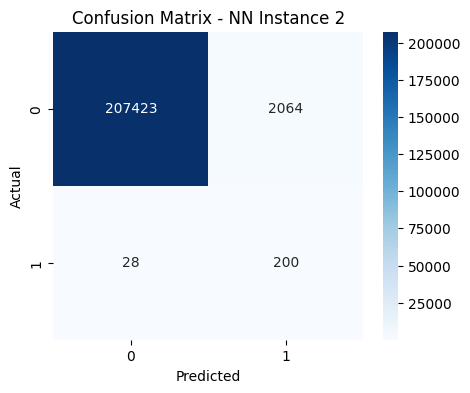

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predict (convert probabilities to 0/1)
y_pred_2 = (model_2.predict(X_val_scaled) > 0.5).astype('int32')
# Confusion Matrix
cm_2 = confusion_matrix(y_val, y_pred_2)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - NN Instance 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [30]:
# Classification Report
print("Classification Report - NN Instance 2:")
print(classification_report(y_val, y_pred_2))

# Individual Metrics (for summary table)
accuracy_2 = accuracy_score(y_val, y_pred_2)
f1_2 = f1_score(y_val, y_pred_2)
precision_2 = precision_score(y_val, y_pred_2)
recall_2 = recall_score(y_val, y_pred_2)

print(f"Accuracy:  {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall:    {recall_2:.4f}")
print(f"F1 Score:  {f1_2:.4f}")


Classification Report - NN Instance 2:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    209487
           1       0.09      0.88      0.16       228

    accuracy                           0.99    209715
   macro avg       0.54      0.93      0.58    209715
weighted avg       1.00      0.99      0.99    209715

Accuracy:  0.9900
Precision: 0.0883
Recall:    0.8772
F1 Score:  0.1605


In [31]:
instance_2_metrics = {
    "Instance": "2",
    "Optimizer": "RMSprop",
    "Regularizer": "L2",
    "Epochs": len(history_2.history['loss']),
    "EarlyStopping": "Yes",
    "Layers": 4,
    "LearningRate": 0.0005,
    "Accuracy": round(accuracy_2, 4),
    "Precision": round(precision_2, 4),
    "Recall": round(recall_2, 4),
    "F1": round(f1_2, 4)
}

print(instance_2_metrics)


{'Instance': '2', 'Optimizer': 'RMSprop', 'Regularizer': 'L2', 'Epochs': 20, 'EarlyStopping': 'Yes', 'Layers': 4, 'LearningRate': 0.0005, 'Accuracy': 0.99, 'Precision': 0.0883, 'Recall': 0.8772, 'F1': 0.1605}


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Optimizer with custom learning rate
optimizer_3 = Adam(learning_rate=0.0003)

# Early stopping
early_stop_3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the model architecture
model_3 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(
    optimizer=optimizer_3,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_3 = model_3.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop_3],
    verbose=1
)


Epoch 1/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9269 - loss: 0.1696 - val_accuracy: 0.9682 - val_loss: 0.0750
Epoch 2/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9688 - loss: 0.0766 - val_accuracy: 0.9582 - val_loss: 0.1044
Epoch 3/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.9718 - loss: 0.0688 - val_accuracy: 0.9832 - val_loss: 0.0510
Epoch 4/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9735 - loss: 0.0648 - val_accuracy: 0.9791 - val_loss: 0.0536
Epoch 5/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9744 - loss: 0.0622 - val_accuracy: 0.9816 - val_loss: 0.0500
Epoch 6/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9748 - loss: 0.0608 - val_accuracy: 0.9858 - val_loss: 0.0401
Epoch 7/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9761 - loss: 0.0586 - val_accuracy: 0.9911 - val_loss: 0.0318
Epoch 8/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 

In [33]:
val_loss_3, val_acc_3 = model_3.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\n✅ Instance 3 - Final Validation Accuracy: {val_acc_3:.4f}")

# Save model
model_3.save('saved_models/nn_instance3_optimized.keras')



✅ Instance 3 - Final Validation Accuracy: 0.9911


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


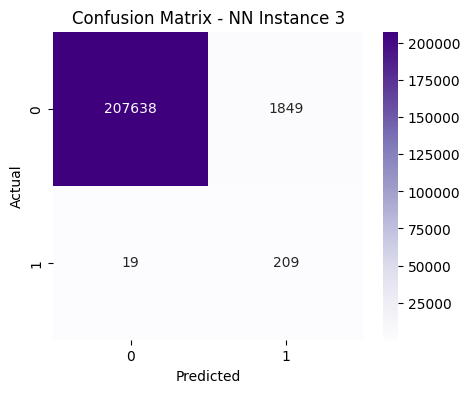

Classification Report - NN Instance 3:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    209487
           1       0.10      0.92      0.18       228

    accuracy                           0.99    209715
   macro avg       0.55      0.95      0.59    209715
weighted avg       1.00      0.99      0.99    209715

Accuracy:  0.9911
Precision: 0.1016
Recall:    0.9167
F1 Score:  0.1829


In [34]:
# Predict on validation set
y_pred_3 = (model_3.predict(X_val_scaled) > 0.5).astype('int32')

# Confusion matrix
cm_3 = confusion_matrix(y_val, y_pred_3)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - NN Instance 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("Classification Report - NN Instance 3:")
print(classification_report(y_val, y_pred_3))

# Individual metrics
accuracy_3 = accuracy_score(y_val, y_pred_3)
f1_3 = f1_score(y_val, y_pred_3)
precision_3 = precision_score(y_val, y_pred_3)
recall_3 = recall_score(y_val, y_pred_3)

print(f"Accuracy:  {accuracy_3:.4f}")
print(f"Precision: {precision_3:.4f}")
print(f"Recall:    {recall_3:.4f}")
print(f"F1 Score:  {f1_3:.4f}")


In [35]:

instance_3_metrics = {
    "Instance": "3",
    "Optimizer": "Adam",
    "Regularizer": "Dropout (0.3)",
    "Epochs": len(history_3.history['loss']),
    "EarlyStopping": "Yes",
    "Layers": 4,
    "LearningRate": 0.0003,
    "Accuracy": round(accuracy_3, 4),
    "Precision": round(precision_3, 4),
    "Recall": round(recall_3, 4),
    "F1": round(f1_3, 4)
}

print(instance_3_metrics)


{'Instance': '3', 'Optimizer': 'Adam', 'Regularizer': 'Dropout (0.3)', 'Epochs': 12, 'EarlyStopping': 'Yes', 'Layers': 4, 'LearningRate': 0.0003, 'Accuracy': 0.9911, 'Precision': 0.1016, 'Recall': 0.9167, 'F1': 0.1829}


In [36]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1

# Optimizer: SGD with custom learning rate
optimizer_4 = SGD(learning_rate=0.01)

# Early stopping
early_stop_4 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model architecture
model_4 = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l1(0.001), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l1(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
model_4.compile(
    optimizer=optimizer_4,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history_4 = model_4.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop_4],
    verbose=1
)


Epoch 1/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.8781 - loss: 0.8096 - val_accuracy: 0.9555 - val_loss: 0.2097
Epoch 2/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9385 - loss: 0.2167 - val_accuracy: 0.9822 - val_loss: 0.1314
Epoch 3/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9442 - loss: 0.1910 - val_accuracy: 0.9750 - val_loss: 0.1275
Epoch 4/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.9463 - loss: 0.1821 - val_accuracy: 0.9559 - val_loss: 0.1659
Epoch 5/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.9484 - loss: 0.1771 - val_accuracy: 0.9328 - val_loss: 0.2003
Epoch 6/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.9488 - loss: 0.1755 - val_accuracy: 0.9913 - val_loss: 0.0963
Epoch 7/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.9492 - loss: 0.1745 - val_accuracy: 0.9876 - val_loss: 0.0993
Epoch 8/50
19640/19640 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 

In [37]:
val_loss_4, val_acc_4 = model_4.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\n✅ Instance 4 - Final Validation Accuracy: {val_acc_4:.4f}")

# Save the model
model_4.save('saved_models/nn_instance4_optimized.keras')



✅ Instance 4 - Final Validation Accuracy: 0.9974


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 4s 613us/step


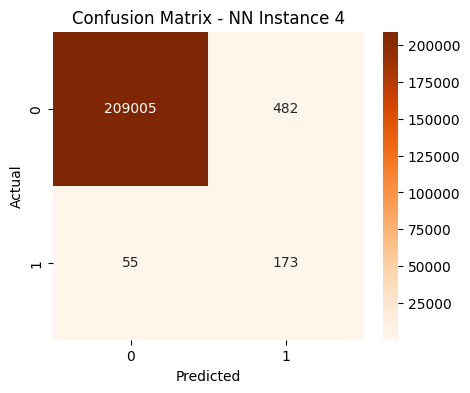

Classification Report - NN Instance 4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.26      0.76      0.39       228

    accuracy                           1.00    209715
   macro avg       0.63      0.88      0.70    209715
weighted avg       1.00      1.00      1.00    209715

Accuracy:  0.9974
Precision: 0.2641
Recall:    0.7588
F1 Score:  0.3918


In [39]:
# Predict
y_pred_4 = (model_4.predict(X_val_scaled) > 0.5).astype('int32')

# Confusion matrix
cm_4 = confusion_matrix(y_val, y_pred_4)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_4, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - NN Instance 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("Classification Report - NN Instance 4:")
print(classification_report(y_val, y_pred_4))

# Individual metrics
accuracy_4 = accuracy_score(y_val, y_pred_4)
f1_4 = f1_score(y_val, y_pred_4)
precision_4 = precision_score(y_val, y_pred_4)
recall_4 = recall_score(y_val, y_pred_4)

print(f"Accuracy:  {accuracy_4:.4f}")
print(f"Precision: {precision_4:.4f}")
print(f"Recall:    {recall_4:.4f}")
print(f"F1 Score:  {f1_4:.4f}")


In [40]:
instance_4_metrics = {
    "Instance": "4",
    "Optimizer": "SGD",
    "Regularizer": "L1 + Dropout (0.3)",
    "Epochs": len(history_4.history['loss']),
    "EarlyStopping": "Yes",
    "Layers": 4,
    "LearningRate": 0.01,
    "Accuracy": round(accuracy_4, 4),
    "Precision": round(precision_4, 4),
    "Recall": round(recall_4, 4),
    "F1": round(f1_4, 4)
}

print(instance_4_metrics)


{'Instance': '4', 'Optimizer': 'SGD', 'Regularizer': 'L1 + Dropout (0.3)', 'Epochs': 15, 'EarlyStopping': 'Yes', 'Layers': 4, 'LearningRate': 0.01, 'Accuracy': 0.9974, 'Precision': 0.2641, 'Recall': 0.7588, 'F1': 0.3918}


#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    209487
           1       0.09      0.84      0.16       228

    accuracy                           0.99    209715
   macro avg       0.54      0.92      0.58    209715
weighted avg       1.00      0.99      0.99    209715

✅ Accuracy :  0.9901
✅ Precision:  0.0860
✅ Recall   :  0.8421
✅ F1 Score :  0.1561


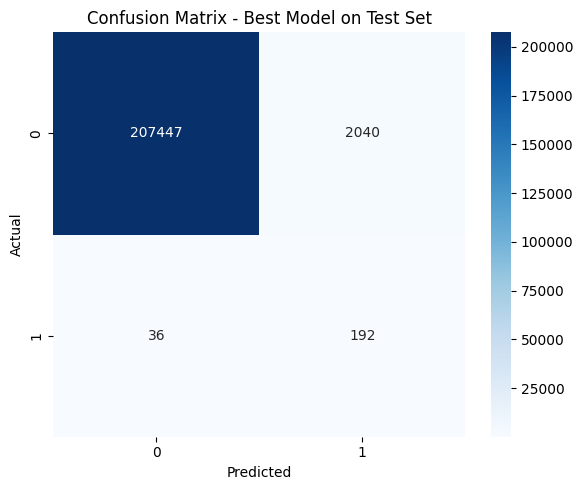

In [ ]:


# === Step 1: Load the best saved model (Instance 2 had best F1 score)
model_path = 'saved_models/nn_instance2_optimized.keras'
model = load_model(model_path)

# === Step 2: Make predictions on the test set
y_pred_test = (model.predict(X_test_scaled) > 0.5).astype("int32")

# === Step 3: Evaluation Metrics
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("📊 Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

print(f"✅ Accuracy :  {acc:.4f}")
print(f"✅ Precision:  {prec:.4f}")
print(f"✅ Recall   :  {rec:.4f}")
print(f"✅ F1 Score :  {f1:.4f}")

# === Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Model on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Congratulations!!
